In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import adjusted_rand_score, roc_curve, roc_auc_score, recall_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.duration.hazard_regression import PHReg

In [2]:
data = pd.read_excel('./data.xlsx')

# Preprocessing

In [3]:
data['Spontanschluck_dich'] = data['Spontanschluck_dich'].apply(lambda x: abs(x-1))

## Target

In [4]:
endpoints = [
    'Pneumonie_Yes_No', # primary endpoint
    'Pneumonie_mult', # secondary endpoint
    'Diff_FEES_Pneumonie', # secondary endpoint
    'Diff_FEES_Tod_day', # secondary endpoint
    'Mortality' # required for Cox Proportional Hazards
]

# Primary Endpoint
y = pneumonia = data[endpoints[0]].values

# Secondary Endpoint
multiple_pneumonia = data[endpoints[1]].values
time_to_pneumonia = data[endpoints[2]].values
time_to_death = data[endpoints[3]].values

## Features

In [5]:
binary_features = [
    'Spontanschluck_dich',
    'Oral_Phase_ohne_Brot',
    'Leaking_patho_new',
    'Swoll_reflex_dich',
    'Triggerpunkt_Sinuspiriformis',
    'Whiteout_pathologisch',
    'Mehrfach_Nachschlucken_ohneBrot',
    'Residue_Sinus_pathologisch',
    'PAS_patho',
]

In [6]:
ada_features = [
    'Spontanschluck_dich',
    'Oral_Phase_ohne_Brot',
    'Leaking_patho_new',
    'Swoll_reflex_dich',
    'Triggerpunkt_Sinuspiriformis',
    'Whiteout_Int',
    'Mehrfach_Nachschlucken_ohneBrot',
    'Residue_Sinus_pathologisch',
    'PAS_Gesamt'
]

## Confounders

In [7]:
covariates = [
    'Demenzstatus',
    'Alter_in_Jahren',
    'BarthelIndexbeiAufnahme',
    'Handgrip',
    'MNA_Punkte',
]

In [8]:
data = data[list(set(binary_features+ada_features+covariates+endpoints))].astype('float')

# Analyses

## Functions

In [9]:
def calculate_score(data, feature_subset, weights=None):
    """
    Compute a weighted sum of selected features to produce a linear score.

    Each feature contributes additively to a final risk or scoring metric.

    Parameters
    ----------
    data : pandas.DataFrame
        Input dataset with feature columns.
    feature_subset : list of str
        Column names of features to include in the score.
    weights : array-like of shape (n_features,), optional
        Feature weights. If None, all weights are set to 1.

    Returns
    -------
    numpy.ndarray of shape (n_samples,)
        Linear score for each sample.
    """
    X = data.reindex(columns=feature_subset).values
    
    if weights is None:
        weights = np.ones(len(feature_subset))
    else:
        weights = np.array(weights)
        if len(weights) != len(feature_subset):
            raise ValueError("Length of weights must match length of feature_subset")
    
    scores = np.dot(X, weights)
    return scores


def optimize_weights_to_integers(data, y, feature_subset, initial_weights, 
                                   max_integer=3, grid_step=0.1):
    """
    Convert continuous weights to small integers while maximizing predictive performance.

    Grid search over multipliers scales continuous weights to integers, selecting
    the set that maximizes ROC AUC without exceeding `max_integer`.

    Parameters
    ----------
    data : pandas.DataFrame
        Feature dataset.
    y : array-like of shape (n_samples,)
        Binary target labels.
    feature_subset : list of str
        Feature names corresponding to `initial_weights`.
    initial_weights : array-like of shape (n_features,)
        Continuous weights to convert.
    max_integer : int, default=3
        Maximum allowed integer weight.
    grid_step : float, default=0.1
        Step size for multiplier search.

    Returns
    -------
    numpy.ndarray of shape (n_features,)
        Optimized integer weights.

    Raises
    ------
    ValueError
        If no valid integer weights can be found within constraints.
    """
    
    initial_weights = np.array(initial_weights, dtype=float)
    best_auc = -np.inf
    best_integer_weights = None
    
    # Grid search over scaling multipliers
    multiplier = grid_step
    max_multiplier = 100  # Safety limit to prevent infinite loops
    
    while multiplier <= max_multiplier:
        # Scale continuous weights and round to integers
        candidate_weights = np.round(initial_weights * multiplier).astype(int)
        
        # Stop if any weight exceeds the maximum allowed value
        if np.any(candidate_weights > max_integer):
            break
        
        # Evaluate ROC AUC with current integer weights
        scores_int = calculate_score(data, feature_subset, candidate_weights)
        current_auc = round(roc_auc_score(y, scores_int), 2)
        
        # Update best solution if current AUC is higher
        if current_auc > best_auc:
            best_auc = current_auc
            best_integer_weights = candidate_weights
        
        multiplier = round(multiplier + grid_step, 2)

    if best_integer_weights is None:
        raise ValueError("No valid integer weights found within constraints")
    return best_integer_weights


def evaluate_feature_combinations(data, y, feature_combinations):
    """
    Rank feature subsets based on clustering agreement with true labels.

    Agglomerative clustering with Ward linkage is applied to each feature subset.
    Quality is measured using Adjusted Rand Index (ARI).

    Parameters
    ----------
    data : pandas.DataFrame
        Dataset with candidate features.
    y : array-like of shape (n_samples,)
        Ground-truth class labels.
    feature_combinations : iterable of iterables
        Collection of feature subsets to evaluate.

    Returns
    -------
    pandas.DataFrame
        Sorted by ARI in descending order. Columns:
        - 'ARI': clustering agreement score
        - 'Feature Set': evaluated feature subset
    """
    results = []
    
    for feature_set in feature_combinations:
        X = data[list(feature_set)]
        
        # Apply agglomerative clustering with Ward linkage
        cluster = AgglomerativeClustering(
            n_clusters=2, 
            metric='euclidean', 
            linkage='ward'
        ).fit(X)
        
        # Measure clustering agreement with ground truth
        ari = adjusted_rand_score(y, cluster.labels_)
        
        results.append({
            'ARI': ari,
            'Feature Set': feature_set
        })
    
    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='ARI', ascending=False).reset_index(drop=True)


def lasso_feature_selection(X, y, n_features=5, max_iter=int(1e6), random_state=42):
    """
    Select a fixed number of features using L1-regularized logistic regression.

    Parameters
    ----------
    X : pandas.DataFrame of shape (n_samples, n_features)
        Feature matrix.
    y : array-like of shape (n_samples,)
        Binary target labels.
    n_features : int, default=5
        Number of features to select.
    max_iter : int, default=1e6
        Maximum solver iterations.
    random_state : int, default=42
        Random seed for reproducibility.

    Returns
    -------
    selected_features : list of str
        Names of selected features.
    coefficients : numpy.ndarray
        Non-zero coefficients corresponding to selected features.

    Raises
    ------
    ValueError
        If exactly `n_features` cannot be selected.
    """
    
    feature_names = X.columns.tolist()
    X_values = X.values
    
    # Search from weak to strong regularization
    C_values = np.logspace(2, -4, int(1e4))  # From 100 to 0.0001
    
    for C in C_values:
        # Fit L1-regularized logistic regression
        # saga solver does not penalize the intercept
        model = LogisticRegression(
            solver='saga',
            l1_ratio=1.0,
            C=C,
            max_iter=max_iter,
            random_state=random_state
        )
        model.fit(X_values, y)
        
        # Identify non-zero coefficients
        coefs = model.coef_[0]
        non_zero_mask = np.abs(coefs) > 1e-10
        n_selected = np.sum(non_zero_mask)
        
        # Check if we've reached the target number of features
        if n_selected <= n_features:
            if n_selected == n_features:
                # Found exact match
                selected_features = [feature_names[i] for i in np.where(non_zero_mask)[0]]
                selected_coefs = coefs[non_zero_mask]
                return selected_features, selected_coefs
            else:
                # Regularization too strong - undershot target
                raise ValueError(
                    f"Could not find C that selects exactly {n_features} features. "
                    f"Got {n_selected} features at C={C:.6f}. Try adjusting n_features."
                )
    
    raise ValueError(
        f"Could not select exactly {n_features} features within C range. "
        "All regularization values resulted in too many features."
    )


def extract_adaboost_rules(model, feature_names):
    """
    Extract decision rules from a fitted AdaBoost classifier.

    Each rule corresponds to a decision stump with a feature, threshold,
    split direction, and estimator weight.

    Parameters
    ----------
    model : AdaBoostClassifier
        Fitted AdaBoost model.
    feature_names : list of str
        Names of input features.

    Returns
    -------
    list of dict
        Each dictionary contains:
        - 'feature' : feature used in split
        - 'threshold' : split value
        - 'direction' : 'greater' or 'less_equal'
        - 'weight' : AdaBoost estimator weight
    """
    rules = []
    
    for i, estimator in enumerate(model.estimators_):
        # Extract split information from decision stump
        tree = estimator.tree_
        feature_idx = tree.feature[0]
        threshold = tree.threshold[0]
        
        # Analyze leaf node class distributions
        # Left child: samples where feature <= threshold
        # Right child: samples where feature > threshold
        left_value = tree.value[1][0]  # Class distribution in left leaf
        right_value = tree.value[2][0]  # Class distribution in right leaf
        
        # Determine which direction predicts positive class
        left_positive_prob = left_value[1] / left_value.sum()
        right_positive_prob = right_value[1] / right_value.sum()
        
        if right_positive_prob > left_positive_prob:
            direction = 'greater'  # feature > threshold predicts positive
        else:
            direction = 'less_equal'  # feature <= threshold predicts positive
        
        rules.append({
            'feature': feature_names[feature_idx],
            'threshold': threshold,
            'direction': direction,
            'weight': model.estimator_weights_[i]
        })
    
    return rules


def binarize_features_from_rules(X, rules):
    """
    Create binary features based on AdaBoost decision rules.

    Each rule generates a binary column indicating whether the condition is met.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix to transform.
    rules : list of dict
        Decision rules with 'feature', 'threshold', and 'direction'.

    Returns
    -------
    list of str
        Names of newly created binary features.
    """
    feature_names = []

    for rule in rules:
        feat = rule["feature"]
        thresh = rule["threshold"]
        direction = rule["direction"]

        # Create descriptive feature name
        name = f"{feat}_{direction}_{round(thresh, 3)}"
        feature_names.append(name)

        # Apply binarization rule
        if direction == "greater":
            X[name] = (X[feat] > thresh).astype(int)
        else:  # less_equal
            X[name] = (X[feat] <= thresh).astype(int)

    return feature_names


def adaboost_feature_selection(X, y, X_test=None, n_stumps=5, random_state=42):
    """
    Select interpretable features using AdaBoost decision stumps.

    Parameters
    ----------
    X : pandas.DataFrame
        Training feature matrix.
    y : array-like
        Binary target labels.
    X_test : pandas.DataFrame, optional
        Test set for applying same binarization rules.
    n_stumps : int, default=5
        Number of decision stumps to fit.
    random_state : int, default=42
        Random seed.

    Returns
    -------
    feature_names : list of str
        Names of binary features created from rules.
    weights : numpy.ndarray
        AdaBoost estimator weights.
    """
    feature_names_orig = X.columns.tolist()

    # Train AdaBoost with decision stumps
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=n_stumps,
        learning_rate=1.0,
        random_state=random_state
    )
    model.fit(X, y)

    # Extract interpretable rules from the fitted model
    rules = extract_adaboost_rules(model, feature_names_orig)
    weights = np.array([r['weight'] for r in rules])
    
    # Create binary features based on extracted rules
    feature_names = binarize_features_from_rules(X, rules)
    
    # Apply same transformation to test set if provided
    if X_test is not None:
        binarize_features_from_rules(X_test, rules) # inplace Operation
    
    return feature_names, weights


def update_results(results, model_key, X_train, y_train, X_test, y_test, feature_subset, weights=None):
    """
    Compute and store ROC AUC scores for train and test sets.

    Parameters
    ----------
    results : dict
        Dictionary for storing scores.
    model_key : str
        Identifier for model.
    X_train, X_test : pandas.DataFrame
        Feature matrices.
    y_train, y_test : array-like
        Binary labels.
    feature_subset : list of str
        Features used in scoring.
    weights : array-like, optional
        Feature weights.
    """
    # Compute scores for both training and test sets
    train_scores = calculate_score(X_train, list(feature_subset), weights)
    test_scores = calculate_score(X_test, list(feature_subset), weights)

    # Calculate ROC AUC and append to results
    results[model_key]['train'].append(roc_auc_score(y_train, train_scores))
    results[model_key]['test'].append(roc_auc_score(y_test, test_scores))


def get_scoring_results(y, scores, n_bootstraps=1000, random_state=None):
    """
    Compute sensitivity, specificity, and Youden Index for all score cutoffs.

    Parameters
    ----------
    y : array-like
        True binary labels.
    scores : array-like
        Predicted scores.
    n_bootstraps : int, default=1000
        Number of bootstrap samples for confidence intervals.
    random_state : int or None
        Random seed.

    Returns
    -------
    pandas.DataFrame
        Columns: cutoff, sensitivity, sensitivity_low, sensitivity_high,
                 specificity, specificity_low, specificity_high, youden_index.
    """
    rng = np.random.RandomState(random_state)
    y = np.asarray(y)
    scores = np.asarray(scores)
    
    unique_scores = sorted(np.unique(scores))
    results = []
    
    for cutoff in unique_scores:
        # Original metrics
        y_pred = (scores >= cutoff).astype(int)
        sensitivity = recall_score(y, y_pred, pos_label=1, zero_division=0)
        specificity = recall_score(y, y_pred, pos_label=0, zero_division=0)
        youden = sensitivity + specificity - 1
        
        # Bootstrap CIs
        boot_sens = []
        boot_spec = []
        
        for _ in range(n_bootstraps):
            indices = rng.randint(0, len(y), len(y))
            
            if len(np.unique(y[indices])) < 2:
                continue
                
            y_boot = y[indices]
            pred_boot = (scores[indices] >= cutoff).astype(int)
            
            boot_sens.append(recall_score(y_boot, pred_boot, pos_label=1, zero_division=0))
            boot_spec.append(recall_score(y_boot, pred_boot, pos_label=0, zero_division=0))
        
        # Calculate 95% CIs
        if boot_sens and boot_spec:
            sens_low = np.percentile(boot_sens, 2.5)
            sens_high = np.percentile(boot_sens, 97.5)
            spec_low = np.percentile(boot_spec, 2.5)
            spec_high = np.percentile(boot_spec, 97.5)
        else:
            sens_low = sens_high = spec_low = spec_high = np.nan
        
        results.append({
            'cutoff': int(cutoff),
            'sensitivity': sensitivity,
            'sensitivity_CI_low': sens_low,
            'sensitivity_CI_high': sens_high,
            'specificity': specificity,
            'specificity_CI_low': spec_low,
            'specificity_CI_high': spec_high,
            'youden_index': youden
        })
    
    return pd.DataFrame(results)


def find_optimal_cutoff(y, scores):
    """
    Find the cutoff that maximizes Youden's J statistic.

    Parameters
    ----------
    y : array-like
        True binary labels.
    scores : array-like
        Predicted scores.

    Returns
    -------
    dict
        Optimal cutoff information with keys:
        - cutoff, index, sensitivity, specificity, fpr, tpr
    """
    y = np.asarray(y)
    scores = np.asarray(scores)
    
    fpr, tpr, thresholds = roc_curve(y, scores)
    
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    
    return {
        'cutoff': thresholds[optimal_idx],
        'index': optimal_idx,
        'sensitivity': tpr[optimal_idx],
        'specificity': 1 - fpr[optimal_idx],
        'fpr': fpr[optimal_idx],
        'tpr': tpr[optimal_idx]
    }


def bootstrap_roc_curve(y, scores, n_bootstraps=1000):
    """
    Compute ROC curve with bootstrapped confidence intervals.

    Parameters
    ----------
    y : array-like
        True binary labels.
    scores : array-like
        Predicted scores.
    n_bootstraps : int, default=1000
        Number of bootstrap samples.

    Returns
    -------
    dict
        Original and mean ROC curves, 95% CIs, and AUC with CI.
    """
    rng = np.random.RandomState(42)
    
    # Original ROC curve
    fpr_orig, tpr_orig, _ = roc_curve(y, scores)
    auc_orig = roc_auc_score(y, scores)
    
    # Fixed interpolation points
    n_points = 1000
    mean_fpr = np.linspace(0, 1, n_points)
    mean_tpr = np.linspace(0, 1, n_points)
    
    # Bootstrap
    tprs = []
    fprs = []
    aucs = []
    
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y), len(y))
        
        y_boot = y[indices]
        scores_boot = scores[indices]
        
        # Compute ROC for bootstrap sample
        fpr_boot, tpr_boot, _ = roc_curve(y_boot, scores_boot)
        
        # Interpolate TPR at fixed FPR points
        tpr_interp = np.interp(mean_fpr, fpr_boot, tpr_boot)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        
        # Interpolate FPR at fixed TPR points
        fpr_interp = np.interp(mean_tpr, tpr_boot, fpr_boot)
        fpr_interp[0] = 0.0
        fprs.append(fpr_interp)
        
        # AUC
        aucs.append(roc_auc_score(y_boot, scores_boot))
    
    tprs = np.array(tprs)
    fprs = np.array(fprs)
    aucs = np.array(aucs)
    
    # Compute 95% CI percentiles
    return {
        'fpr_orig': fpr_orig,
        'tpr_orig': tpr_orig,
        'fpr': mean_fpr,
        'tpr': tprs.mean(axis=0),
        'tpr_lower': np.percentile(tprs, 2.5, axis=0),
        'tpr_upper': np.percentile(tprs, 97.5, axis=0),
        'mean_tpr_points': mean_tpr,
        'fpr_lower': np.percentile(fprs, 2.5, axis=0),
        'fpr_upper': np.percentile(fprs, 97.5, axis=0),
        'auc': auc_orig,
        'auc_lower': np.percentile(aucs, 2.5),
        'auc_upper': np.percentile(aucs, 97.5)
    }

    
def plot_roc(y, scores, ax, label=None, color=None, show_ci=True, 
             optimal_cutoff=None, n_bootstraps=1000):
    """
    Plot ROC curve with optional bootstrap confidence intervals and optimal cutoff.

    Parameters
    ----------
    y : array-like
        True binary labels.
    scores : array-like
        Predicted scores.
    ax : matplotlib axis
        Axis to plot on.
    label : str, optional
        Curve label.
    color : str, optional
        Curve color.
    show_ci : bool, default=True
        Show confidence intervals.
    optimal_cutoff : float or dict, optional
        Highlight optimal threshold.
    n_bootstraps : int, default=1000
        Number of bootstrap samples.

    Returns
    -------
    matplotlib axis
    """
    
    # Compute ROC with bootstrap CIs if requested
    if show_ci:
        roc_result = bootstrap_roc_curve(y, scores, n_bootstraps=n_bootstraps)
        fpr = roc_result['fpr_orig']
        tpr = roc_result['tpr_orig']
        auc = roc_result['auc']
        auc_lower = roc_result['auc_lower']
        auc_upper = roc_result['auc_upper']
        
        auc_text = f"AUC = {auc:.2f} [{auc_lower:.2f}-{auc_upper:.2f}]"
        
        # Plot tube-style confidence interval (both FPR and TPR uncertainty)
        ax.fill_betweenx(
            roc_result['mean_tpr_points'],
            roc_result['fpr_lower'],
            roc_result['fpr_upper'],
            color=color, alpha=0.05, label='_nolegend_'
        )
        ax.fill_between(
            roc_result['fpr'],
            roc_result['tpr_lower'],
            roc_result['tpr_upper'],
            color=color, alpha=0.05, label='_nolegend_'
        )
    else:
        fpr, tpr, _ = roc_curve(y, scores)
        auc = roc_auc_score(y, scores)
        auc_text = f"AUC = {auc:.2f}"
    
    plot_label = f"{label} \n{auc_text}" if label else auc_text
    ax.plot(fpr, tpr, linewidth=2.5, label=plot_label, color=color)
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Guessing')
    
    # Highlight optimal cutoff
    if isinstance(optimal_cutoff, dict):
        opt_fpr = optimal_cutoff['fpr']
        opt_tpr = optimal_cutoff['tpr']
        sens = optimal_cutoff['sensitivity']
        spec = optimal_cutoff['specificity']
        
        # Draw crosshairs
        ax.plot([0, opt_fpr], [opt_tpr, opt_tpr], 'k--', linewidth=1, 
               alpha=0.5, label='_nolegend_')
        ax.plot([opt_fpr, opt_fpr], [0, opt_tpr], 'k--', linewidth=1, 
               alpha=0.5, label='_nolegend_')
        
        # Mark point
        ax.plot(opt_fpr, opt_tpr, 'x', color='black', markersize=8, 
               markeredgewidth=2, markerfacecolor='black', label='_nolegend_')
        
        ax.annotate(
            f'Optimal cut-off\nSensitivity = {sens:.2f}\nSpecificity = {spec:.2f}',
            xy=(opt_fpr, opt_tpr),
            xytext=(opt_fpr + 0.03, opt_tpr - 0.08),
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                    edgecolor='black', alpha=0.5)
        )
    
    ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    ax.legend(loc='lower right', fontsize=10, framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    
    return ax


def standardize_beta(beta, se, sd_x, sd_y=None, alpha=0.05):
    """
    Compute standardized beta coefficient and confidence interval.

    Parameters
    ----------
    beta : float
        Regression coefficient.
    se : float
        Standard error.
    sd_x : float
        Predictor standard deviation.
    sd_y : float or None
        Outcome standard deviation (for full standardization).
    alpha : float, default=0.05
        Significance level for confidence interval.

    Returns
    -------
    tuple
        beta_std, ci_low, ci_high
    """
    scale = sd_x if sd_y is None else sd_x / sd_y

    beta_std = beta * scale
    se_std = se * scale

    z = 1.96 if alpha == 0.05 else stats.norm.ppf(1 - alpha / 2)

    ci_low = beta_std - z * se_std
    ci_high = beta_std + z * se_std

    return beta_std, ci_low, ci_high


def analyze_binary_score(data, score, outcome, covariates):
    """
    Logistic regression of a binary outcome with covariate adjustment.

    Parameters
    ----------
    data : pandas.DataFrame
    score : str
        Name of score variable.
    outcome : str
        Binary outcome variable.
    covariates : list of str
        Covariate names.

    Returns
    -------
    dict or None
        Odds ratio and CI, or None if outcome has no variation.
    """
    cols = [score, outcome] + covariates
    df = data[cols].dropna()

    if df[outcome].nunique() < 2:
        return None

    X = sm.add_constant(df[[score] + covariates])
    y = df[outcome]

    model = sm.Logit(y, X).fit(disp=False)

    beta = model.params[score]
    se = model.bse[score]
    p_value = model.pvalues[score]

    or_value = np.exp(beta)
    ci_low = np.exp(beta - 1.96 * se)
    ci_high = np.exp(beta + 1.96 * se)

    return {
        "Score": score,
        "Outcome": outcome,
        "OR": or_value,
        "CI_low": ci_low,
        "CI_high": ci_high,
        "p-value": p_value,
    }


def analyze_cox_hr_score(data, score, time_col, event_col, covariates):
    """
    Cox proportional hazards regression with covariate adjustment.

    Parameters
    ----------
    data : pandas.DataFrame
    score : str
        Name of score variable.
    time_col : str
        Column name for survival time.
    event_col : str
        Column name for event indicator (1=event, 0=censored).
    covariates : list of str
        Covariate names.

    Returns
    -------
    dict or None
        Hazard ratio and CI, or None if insufficient events (<5).
    """
    cols = [score, time_col, event_col] + covariates
    df = data[cols].dropna()

    # Require sufficient number of events
    if df[event_col].sum() < 5:
        return None

    X = df[[score] + covariates]  # NO intercept for Cox models
    time = df[time_col]
    event = df[event_col]

    model = PHReg(time, X, status=event)
    result = model.fit()

    # Convert to pandas Series to allow column-name lookup
    params = pd.Series(result.params, index=X.columns)
    bse = pd.Series(result.bse, index=X.columns)

    beta = params[score]
    se = bse[score]
    p_value = result.pvalues[0]  # PHReg returns p-values as ndarray

    hr = np.exp(beta)
    ci_low = np.exp(beta - 1.96 * se)
    ci_high = np.exp(beta + 1.96 * se)

    return {
        "Score": score,
        "Outcome": f"{time_col} / {event_col}",
        "HR": hr,
        "CI_low": ci_low,
        "CI_high": ci_high,
        "p-value": p_value,
    }
    

def analyze_associations(data, scores, lr_outcomes, cox_hr_outcomes, covariates):
    """
    Analyze associations of multiple scores with outcomes using regression.

    Binary outcomes → logistic regression (OR).
    Time-to-event outcomes → Cox proportional hazards regression (HR).

    Parameters
    ----------
    data : pandas.DataFrame
    scores : list of str
        Score variables.
    lr_outcomes : list of str
        Binary outcome variables.
    cox_hr_outcomes : list of tuples
        Time-to-event outcomes: (time_column, event_column).
    covariates : list of str
        Covariate names.

    Returns
    -------
    pandas.DataFrame
        Columns: Score, Outcome, Model, Effect type, Estimate (95% CI), p-value.
    """
    results = []

    for score in scores:

        # Binary outcomes → Logistic regression (OR)
        for target in lr_outcomes:
            res = analyze_binary_score(
                data, score, target, covariates
            )
            if res is not None:
                results.append({
                    "Score": score,
                    "Outcome": target,
                    "Model": "Logistic",
                    "Effect type": "OR",
                    "Estimate (95% CI)": f"{res['OR']:.2f} ({res['CI_low']:.2f}–{res['CI_high']:.2f})",
                    "p-value": res["p-value"],
                })

        # Time-to-event outcomes → Cox PH (HR)
        for time_col, event_col in cox_hr_outcomes:
            res = analyze_cox_hr_score(
                data, score, time_col, event_col, covariates
            )
            if res is not None:
                results.append({
                    "Score": score,
                    "Outcome": time_col,
                    "Model": "Cox PH",
                    "Effect type": "HR",
                    "Estimate (95% CI)": f"{res['HR']:.2f} ({res['CI_low']:.2f}–{res['CI_high']:.2f})",
                    "p-value": res["p-value"],
                })

    return (
        pd.DataFrame(results)
        .sort_values(by=["Score", "Outcome"])
        .reset_index(drop=True)
    )


## Clustering

In [10]:
feature_combinations = [
    combo for r in range(1, len(binary_features) + 1) 
    for combo in combinations(binary_features, r)
]

clustering_df = evaluate_feature_combinations(data, y, feature_combinations)
pneumonia_pattern = list(clustering_df.loc[0, 'Feature Set'])

pd.set_option('display.max_colwidth', 200)
clustering_df.head(5).style \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]) \
    .hide(axis="index")

ARI,Feature Set
0.156283,"('Oral_Phase_ohne_Brot', 'Swoll_reflex_dich', 'Whiteout_pathologisch', 'Mehrfach_Nachschlucken_ohneBrot', 'Residue_Sinus_pathologisch', 'PAS_patho')"
0.145264,"('Swoll_reflex_dich', 'PAS_patho')"
0.145264,"('Swoll_reflex_dich', 'Whiteout_pathologisch', 'Residue_Sinus_pathologisch', 'PAS_patho')"
0.145264,"('Swoll_reflex_dich',)"
0.145264,"('Spontanschluck_dich', 'Oral_Phase_ohne_Brot', 'Swoll_reflex_dich', 'Mehrfach_Nachschlucken_ohneBrot')"


## Scoring Systems

### 5-fold cross-validation

In [11]:
results = {
    model_name: {
        "train": (train_list := []),
        "test": (test_list := [])
    }
    for model_name in ["Clustering", "LASSO", "AdaBoost"]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(data, y):
    
    # Split data
    data_train, data_test = data.iloc[train_idx], data.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Clustering
    clustering_data = [data_train[binary_features], y_train, data_test[binary_features], y_test]
    clustering_features = evaluate_feature_combinations(*clustering_data[:2], feature_combinations).loc[0, 'Feature Set']
    update_results(results, 'Clustering', *clustering_data, clustering_features)
    
    # LASSO Logistic Regression
    lasso_data = [data_train[binary_features], y_train, data_test[binary_features], y_test]
    lasso_features, lasso_weights = lasso_feature_selection(*lasso_data[:2])
    lasso_integer_weights = optimize_weights_to_integers(*lasso_data[:2], lasso_features, lasso_weights)
    update_results(results, 'LASSO', *lasso_data, lasso_features, lasso_integer_weights)
    
    # AdaBoost
    ada_data = [data_train.loc[:, ada_features], y_train, data_test.loc[:, ada_features], y_test]
    ada_bin_features, ada_weights = adaboost_feature_selection(*ada_data[:3])
    ada_integer_weights = optimize_weights_to_integers(*ada_data[:2], ada_bin_features, ada_weights)
    update_results(results, 'AdaBoost', *ada_data, ada_bin_features, ada_integer_weights)

for model_name, scores in results.items():
    print(model_name)
    print(f"Train ROC AUC = {np.round(np.array(scores['train']).mean(), 2)}")
    print(f"Test ROC AUC = {np.round(np.array(scores['test']).mean(), 2)}\n")

Clustering
Train ROC AUC = 0.69
Test ROC AUC = 0.66

LASSO
Train ROC AUC = 0.74
Test ROC AUC = 0.61

AdaBoost
Train ROC AUC = 0.76
Test ROC AUC = 0.58



### All Data

#### Clustering

In [12]:
X = data[list(pneumonia_pattern)]
best_model = AgglomerativeClustering(n_clusters=2, metric='euclidean', compute_distances=True).fit(X)
data['clustering_score'] = data[list(pneumonia_pattern)].sum(axis=1)

print('Scoring System')
for feature, weight in  (zip(pneumonia_pattern, [1 for _ in range(6)])):
    print(f"- {feature:40}{weight}")
print()

roc_result = bootstrap_roc_curve(y, data['clustering_score'])
print(f'ROC AUC (95% CI): {roc_result['auc']:.2f} ({roc_result['auc_lower']:.2f}-{roc_result['auc_upper']:.2f})')

Scoring System
- Oral_Phase_ohne_Brot                    1
- Swoll_reflex_dich                       1
- Whiteout_pathologisch                   1
- Mehrfach_Nachschlucken_ohneBrot         1
- Residue_Sinus_pathologisch              1
- PAS_patho                               1

ROC AUC (95% CI): 0.73 (0.61-0.82)


#### LASSO Logistic Regression

In [13]:
X = data[binary_features]
lasso_features, lasso_weights = lasso_feature_selection(X, y)
lasso_integer_weights = optimize_weights_to_integers(X, y, lasso_features, lasso_weights)
data['lasso_score'] = calculate_score(X, lasso_features, lasso_integer_weights)

print('Scoring System')
for feature, weight in zip(lasso_features, [int(w) for w in lasso_integer_weights]):
    print(f"- {feature:40}{weight}")
print()

roc_result = bootstrap_roc_curve(y, data['lasso_score'])
print(f'ROC AUC (95% CI): {roc_result['auc']:.2f} ({roc_result['auc_lower']:.2f}-{roc_result['auc_upper']:.2f})')

Scoring System
- Oral_Phase_ohne_Brot                    1
- Swoll_reflex_dich                       2
- Mehrfach_Nachschlucken_ohneBrot         1
- Residue_Sinus_pathologisch              1
- PAS_patho                               1

ROC AUC (95% CI): 0.73 (0.62-0.82)


#### AdaBoost

In [14]:
X = data.loc[:, ada_features]
ada_bin_features, ada_weights = adaboost_feature_selection(X, y)
ada_integer_weights = optimize_weights_to_integers(X, y, ada_bin_features, ada_weights)
data['ada_score'] = calculate_score(X, ada_bin_features, ada_integer_weights)

print('Scoring System')
for feature, weight in zip(ada_bin_features, [int(w) for w in ada_integer_weights]):
    print(f"- {feature:40}{weight}")
print()

roc_result = bootstrap_roc_curve(y, data['ada_score'])
print(f'ROC AUC (95% CI): {roc_result['auc']:.2f} ({roc_result['auc_lower']:.2f}-{roc_result['auc_upper']:.2f})')

Scoring System
- Swoll_reflex_dich_greater_0.5           1
- PAS_Gesamt_greater_3.5                  1
- Residue_Sinus_pathologisch_greater_0.5  1
- PAS_Gesamt_less_equal_1.5               1
- PAS_Gesamt_greater_3.5                  0

ROC AUC (95% CI): 0.74 (0.63-0.83)


### ROC Curve

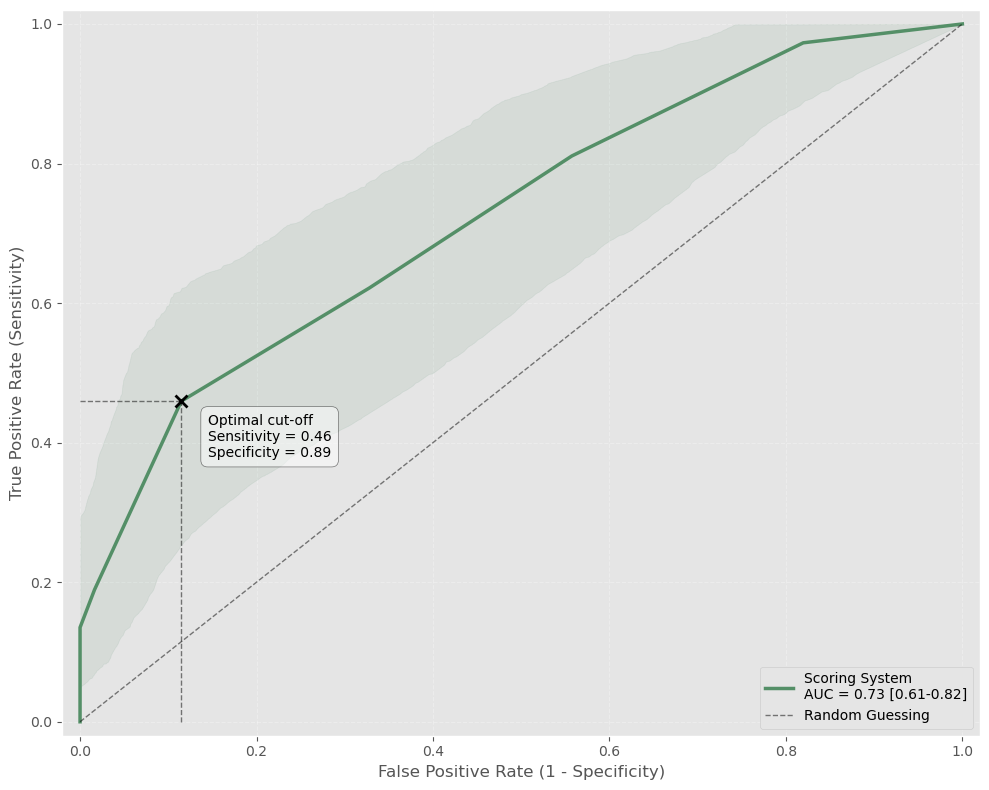

In [15]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 8))
optimal = find_optimal_cutoff(y, data['clustering_score'])
    
plot_roc(y, data['clustering_score'], ax, label='Scoring System', color='#548F67', show_ci=True, optimal_cutoff=optimal)
    
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')

In [16]:
scoring_results = get_scoring_results(y, data['clustering_score'])
scoring_results.to_excel('./clustering_score.xlsx', index=False)
scoring_results.style.hide(axis="index")

cutoff,sensitivity,sensitivity_CI_low,sensitivity_CI_high,specificity,specificity_CI_low,specificity_CI_high,youden_index
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1,0.972973,0.909038,1.000000,0.180328,0.094325,0.281250,0.153301
2,0.810811,0.681737,0.925023,0.442623,0.320755,0.568972,0.253434
3,0.621622,0.454472,0.769286,0.672131,0.563581,0.784697,0.293753
4,0.459459,0.295421,0.611111,0.885246,0.796610,0.957271,0.344705
5,0.189189,0.078947,0.315822,0.983607,0.945455,1.000000,0.172796
6,0.135135,0.034454,0.257166,1.000000,1.000000,1.000000,0.135135


## Secondary Endpoints

In [17]:
scores = ['clustering_score']
lr_outcomes = ['Pneumonie_Yes_No', 'Pneumonie_mult']
cox_hr_outcomes = [
    ('Diff_FEES_Pneumonie', 'Pneumonie_Yes_No'), 
    ('Diff_FEES_Tod_day', 'Mortality')
]

endpoints = analyze_associations(data, scores, lr_outcomes, cox_hr_outcomes, covariates)
endpoints.to_excel('./endpoints.xlsx', index=False)
endpoints.style.hide(axis="index")

Score,Outcome,Model,Effect type,Estimate (95% CI),p-value
clustering_score,Diff_FEES_Pneumonie,Cox PH,HR,1.48 (1.16–1.89),0.001897
clustering_score,Diff_FEES_Tod_day,Cox PH,HR,1.21 (0.99–1.46),0.058081
clustering_score,Pneumonie_Yes_No,Logistic,OR,1.82 (1.24–2.67),0.002375
clustering_score,Pneumonie_mult,Logistic,OR,2.01 (1.31–3.09),0.001434
